# Survival/Churn Analysis

Adapted from [Anurag Pandey's Article](https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e)

In [ ]:
!pip install lifelines --upgrade

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from lifelines.plotting import plot_lifetimes      # Lifelines package for the Survival Analysis
from lifelines import CoxPHFitter     # The Cox Proportional Hazard Regression Model from Lifelines
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


### Example with a fictitious data

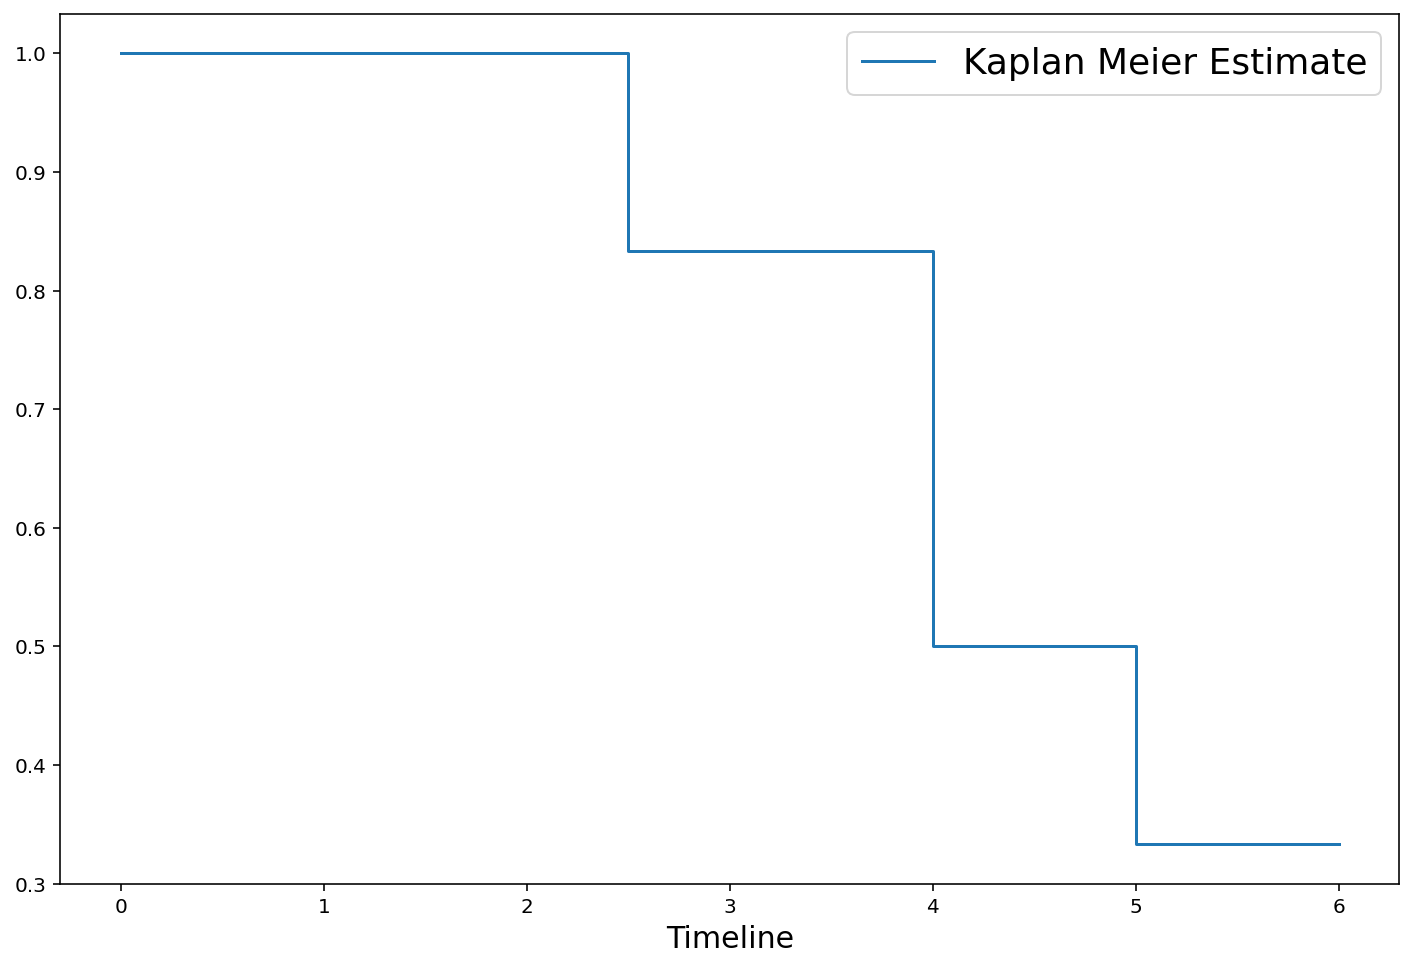

In [42]:
from lifelines import KaplanMeierFitter

## Example Data 
durations = [5,6,6,2.5,4,4]
event_observed = [1, 0, 0, 1, 1, 1]

## create an kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
kmf.plot(ci_show=False, figsize=(12,8)) ## ci_show is meant for Confidence Interval. Since our data set is so tiny, I am not showing it.
plt.xlabel('Timeline', fontsize=15)
plt.legend(fontsize=18);

## Real World Example 

### We will be using Telco Customer Churn data from Kaggle
https://www.kaggle.com/blastchar/telco-customer-churn/

In [43]:
##  create a dataframe
df = pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv") 

In [44]:
## Have a first look at the data
df.head() 

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [45]:
## Data Types and Missing Values in Columns
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [46]:
## Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

## Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censured data.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [47]:
## after converting the column TotalCharges to numeric
df.info()  ## Column TotalCharges is having missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [48]:
## Impute the null values with the median value

df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)

In [49]:
## Create a list of Categorical Columns
cat_cols= [i  for i in df.columns if df[i].dtype==object]
cat_cols.remove('customerID')  ## customerID has been removed because it is unique for all the rows.

In [50]:
## lets have a look at the categories and their distribution in all the categorical columns.

for i in cat_cols:
    print('Column Name: ',i)
    print(df[i].value_counts())
    print('---------------------------------')

Column Name:  gender
Male      3555
Female    3488
Name: gender, dtype: int64
---------------------------------
Column Name:  Partner
No     3641
Yes    3402
Name: Partner, dtype: int64
---------------------------------
Column Name:  Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64
---------------------------------
Column Name:  PhoneService
Yes    6361
No      682
Name: PhoneService, dtype: int64
---------------------------------
Column Name:  MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
---------------------------------
Column Name:  InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
---------------------------------
Column Name:  OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
---------------------------------
Column Name:  OnlineBackup
No      

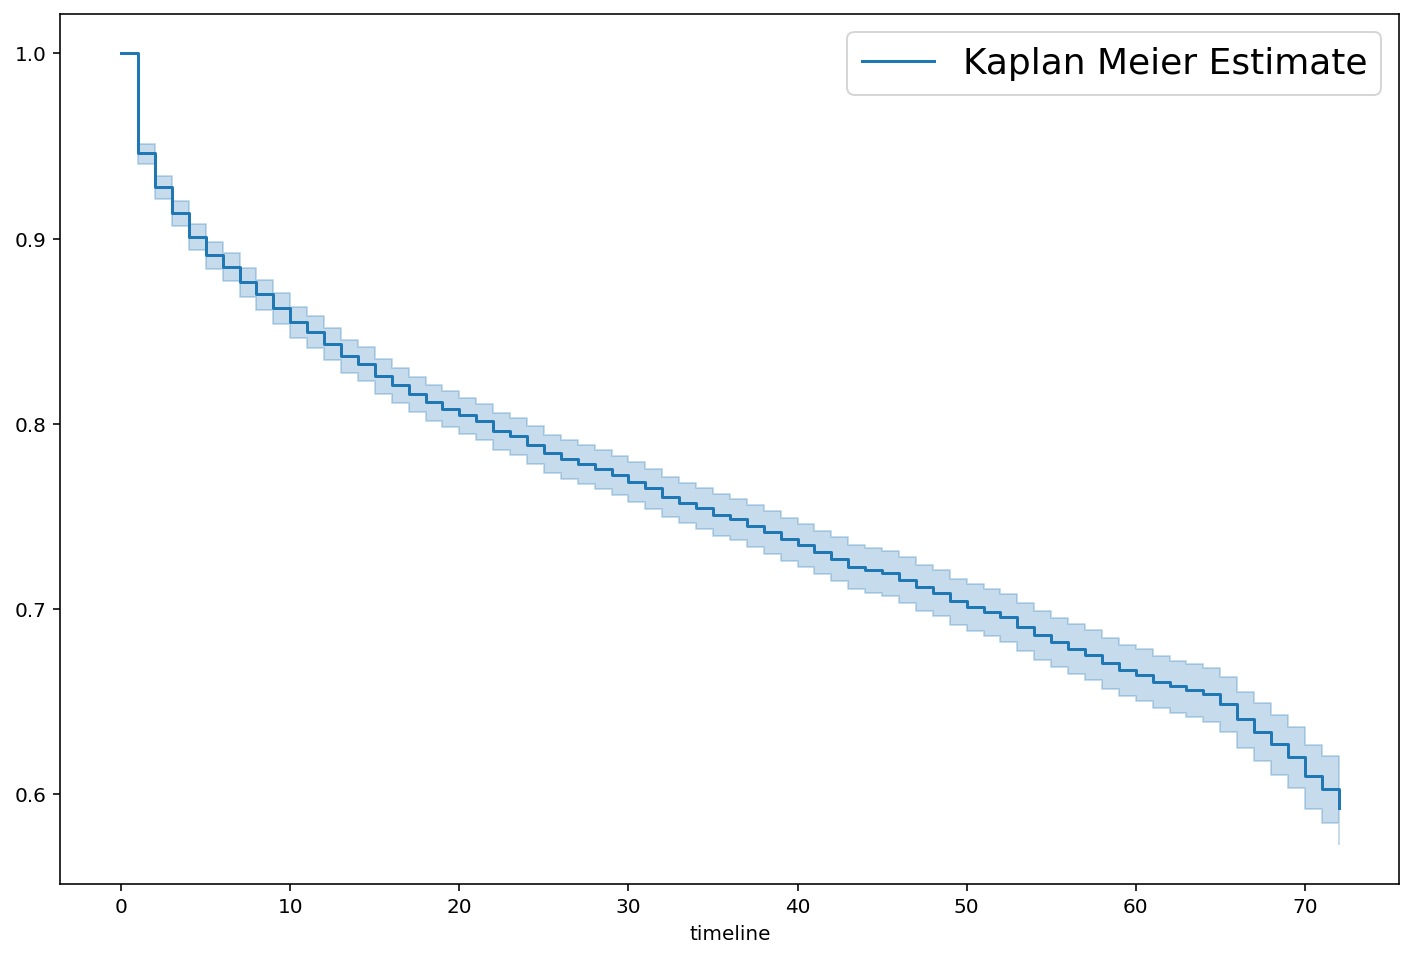

In [51]:
## Lets create an overall KaplanMeier curve, without breaking it into groups of covariates.

## Import the library
from lifelines import KaplanMeierFitter

durations = df['tenure'] ## Time to event data of censored and event data
event_observed = df['Churn']  ## It has the churned (1) and censored is (0)

## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
km.plot(figsize=(12,8))
plt.legend(fontsize=18);

## Lets create Kaplan Meier Curves for Cohorts

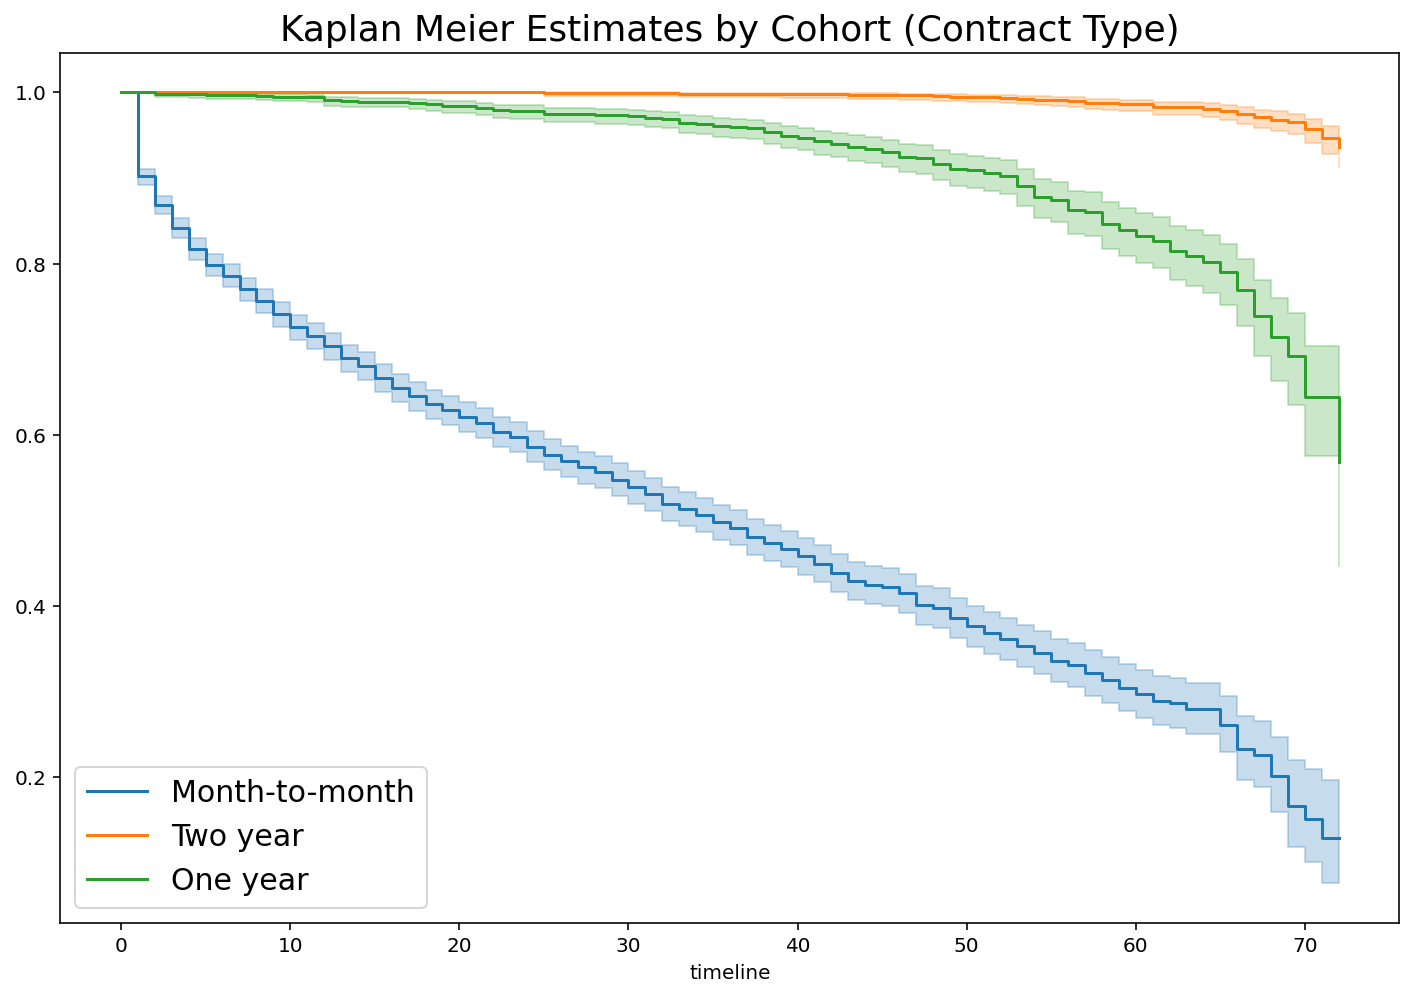

In [52]:
kmf = KaplanMeierFitter() 

T = df['tenure']     ## time to event
E = df['Churn']      ## event occurred or censored

groups = df['Contract']             ## Create the cohorts from the 'Contract' column
ix1 = (groups == 'Month-to-month')   ## Cohort 1
ix2 = (groups == 'Two year')         ## Cohort 2
ix3 = (groups == 'One year')         ## Cohort 3

kmf.fit(T[ix1], E[ix1], label='Month-to-month')    ## fit the cohort 1 data
ax = kmf.plot()

kmf.fit(T[ix2], E[ix2], label='Two year')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)

kmf.fit(T[ix3], E[ix3], label='One year')        ## fit the cohort 3 data
kmf.plot(ax=ax1, figsize=(12,8));               ## Plot the KM curve for three cohort on same x and y axis

plt.title('Kaplan Meier Estimates by Cohort (Contract Type)', fontsize=18)
plt.legend(fontsize=15);

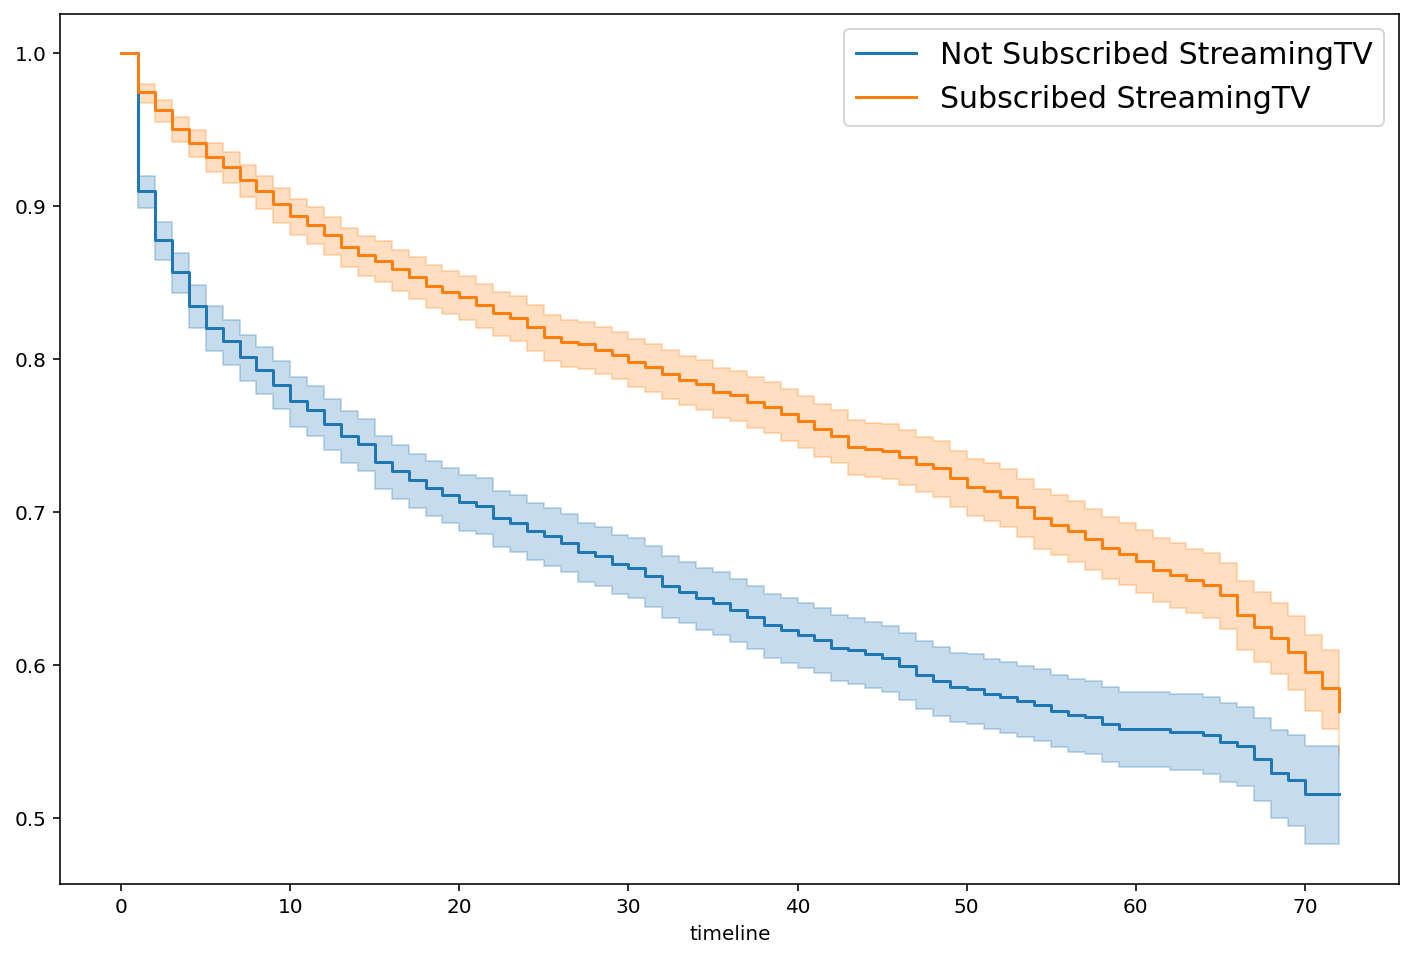

In [53]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. 1. Streaming TV Not Subsribed by Users, 2. Streaming TV subscribed by the users.
groups = df['StreamingTV']   
i1 = (groups == 'No')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Yes')     ## group i2 , having the pandas series for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Not Subscribed StreamingTV')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Subscribed StreamingTV')
kmf1.plot(ax=a1, figsize=(12,8))
plt.legend(fontsize=15);

## Cox Proportional Hazard Model (Survival Regression)

In [54]:
## My objective here is to introduce you to the implementation of the model. Thus, taking subset of the columns to train the model.
## Only using the subset of the columns present in the original data
df_r= df.loc[:,['tenure','Churn','gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]
df_r.head() ## have a look at the data 

,tenure,Churn,gender,Partner,Dependents,PhoneService,MonthlyCharges,SeniorCitizen,StreamingTV
0,1,0,Female,Yes,No,No,29.85,0,No
1,34,0,Male,No,No,Yes,56.95,0,No
2,2,1,Male,No,No,Yes,53.85,0,No
3,45,0,Male,No,No,No,42.30,0,No
4,2,1,Female,No,No,Yes,70.70,0,No


In [55]:
## Create dummy variables
df_dummy = pd.get_dummies(df_r, drop_first=True)
df_dummy.head()

,tenure,Churn,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,1,0,29.85,0,0,1,0,0,0,0
1,34,0,56.95,0,1,0,0,1,0,0
2,2,1,53.85,0,1,0,0,1,0,0
3,45,0,42.30,0,1,0,0,0,0,0
4,2,1,70.70,0,0,0,0,1,0,0


In [56]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a Cox Proportional Hazard (cph) object
cph.fit(df_dummy, 'tenure', event_col='Churn')   ## Fit the data to train the model
cph.print_summary()    ## Have a look at the significance of the features

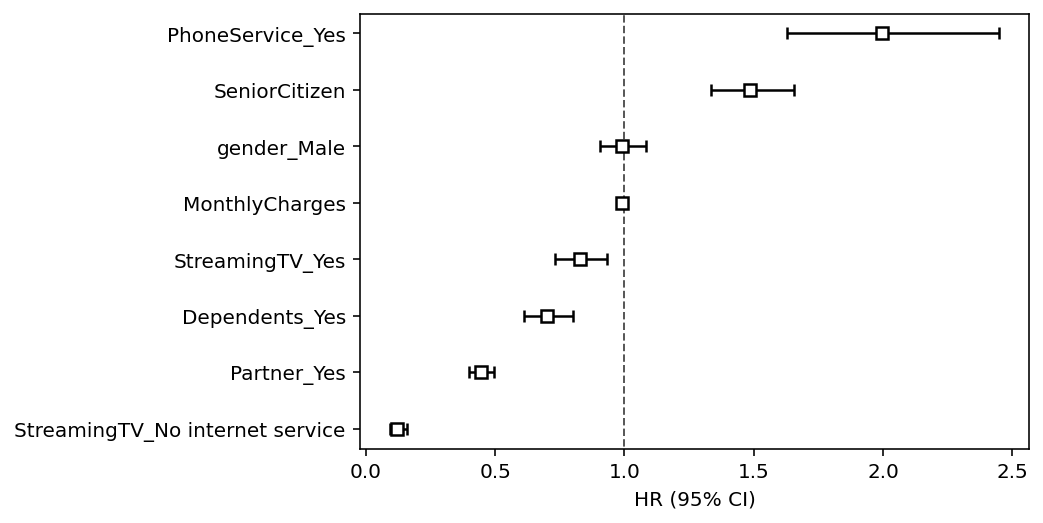

In [57]:
cph.plot(hazard_ratios=True);

### This is where you might want to dive more deeply into the results to see if anything can explain what is going on. 

### For example, with Senior Citizen and Phone Service

In [58]:
df.groupby('SeniorCitizen').mean()

,tenure,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,,,,
0,32.192171,61.847441,2179.628821,0.236062
1,33.295972,79.820359,2810.465193,0.416813


In [35]:
print(df.PhoneService.value_counts(normalize=True))
print(df.PhoneService.value_counts())

Yes    0.903166
No     0.096834
Name: PhoneService, dtype: float64
Yes    6361
No      682
Name: PhoneService, dtype: int64


#### So the vast majority of our customers have phone service, but maybe there is an interaction effect worth exploring between Senior Citizens and Phone Service?

In [33]:
df.groupby('PhoneService')['SeniorCitizen'].sum()

PhoneService
No      104
Yes    1038
Name: SeniorCitizen, dtype: int64

In [60]:
df_dummy['SC_PS_interaction'] = df_dummy.SeniorCitizen*df_dummy.PhoneService_Yes

In [61]:
# Rerunning the Cox Proportional Hazards model with the new interaction term
cph = CoxPHFitter()   ## Instantiate the class to create a Cox Proportional Hazard (cph) object
cph.fit(df_dummy, 'tenure', event_col='Churn')   ## Fit the data to train the model
cph.print_summary()    ## Have a look at the significance of the features

In [62]:
## We want to see the Survival curve at the customer level. Therefore, we have selected 6 customers (rows 5 till 9).

tr_rows = df_dummy.iloc[5:10, 2:]
tr_rows

,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes,SC_PS_interaction
5,99.65,0,0,0,0,1,0,1,0
6,89.10,0,1,0,1,1,0,1,0
7,29.75,0,0,0,0,0,0,0,0
8,104.80,0,0,1,0,1,0,1,0
9,56.15,0,1,0,1,1,0,0,0


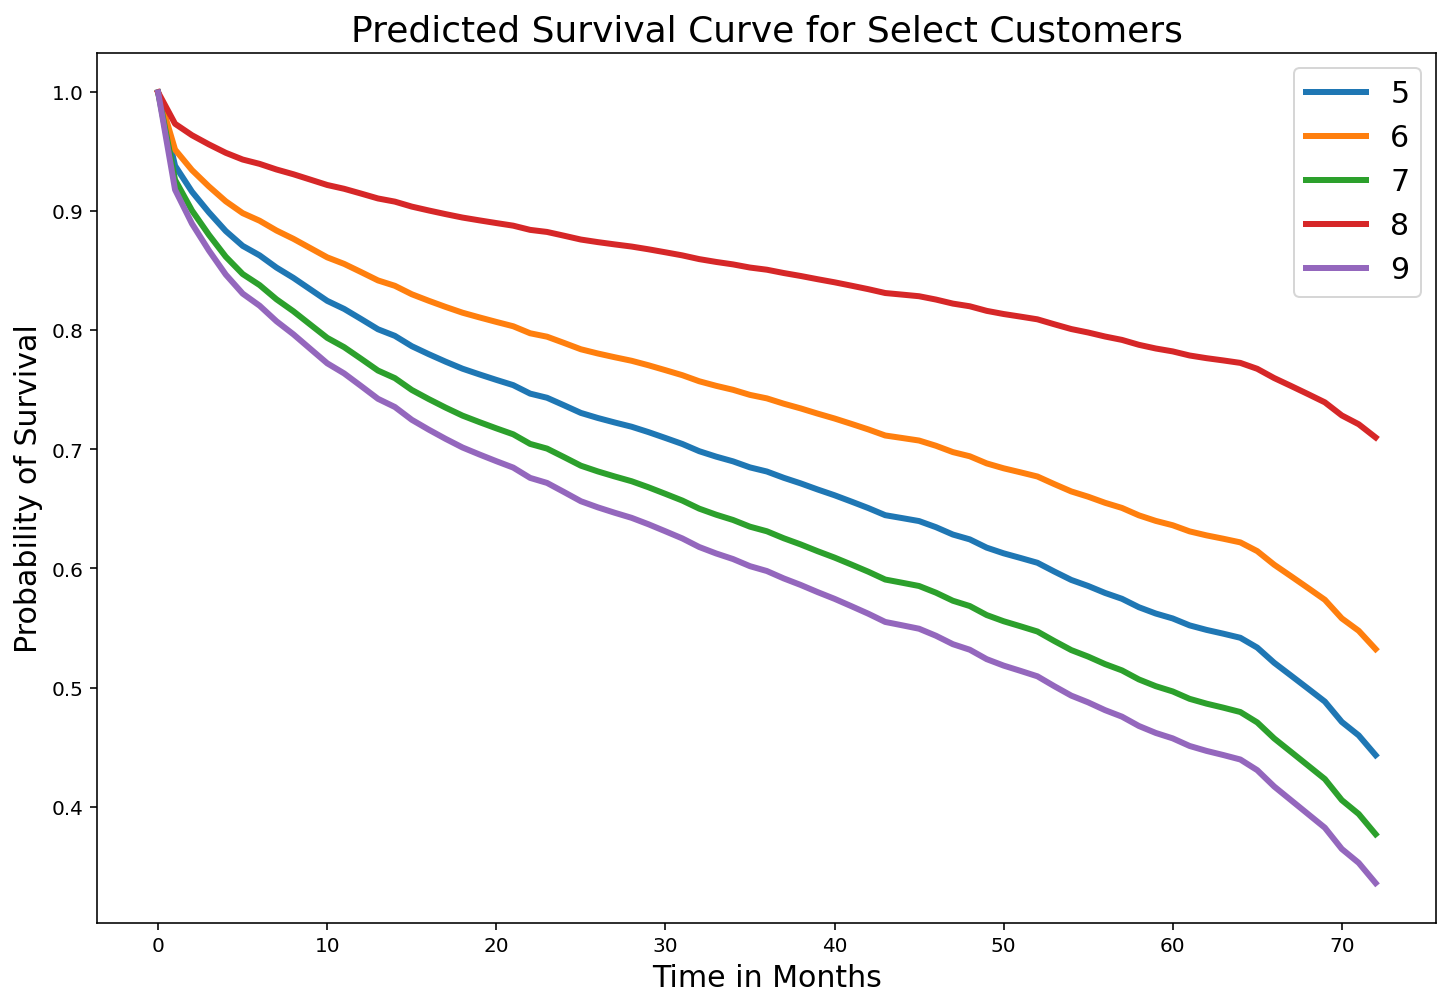

In [63]:
## Lets predict the survival curve for the selected customers. 
## Customers can be identified with the help of the number mentioned against each curve.
cph.predict_survival_function(tr_rows).plot(figsize=(12,8), linewidth=3)
plt.title('Predicted Survival Curve for Select Customers', fontsize=18)
plt.ylabel('Probability of Survival', fontsize=15)
plt.xlabel('Time in Months', fontsize=15)
plt.legend(fontsize=15);

## That's about all I have for you. Here is a neat trick in case you didn't know. You can see all the methods and attributes of the CPH object. This can be done with all the models we've covered throughout this course. 

In [64]:
## Check all the methods and attributes associated with the cph object.
dir(cph)

['AIC_partial_',
 '_ALLOWED_RESIDUALS',
 '_KNOWN_MODEL',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_mode',
 '_censoring_type',
 '_check_values_post_fitting',
 '_check_values_pre_fitting',
 '_class_name',
 '_clusters',
 '_compute_baseline_cumulative_hazard',
 '_compute_baseline_hazard',
 '_compute_baseline_hazards',
 '_compute_baseline_survival',
 '_compute_confidence_intervals',
 '_compute_delta_beta',
 '_compute_deviance',
 '_compute_martingale',
 '_compute_p_values',
 '_compute_sandwich_estimator',
 '_compute_scale_schoenfeld',
 '_compute_scaled_schoenfeld',
 '_compute_schoenfeld',
 '_compute_schoenfeld_within_strata',
 '_compute_scor